# **2. 케글 데이터셋 **
* [케글] (https://www.kaggle.com/)에 로그인
* 우측상단의 계정을 클릭 - > yout profile -> 우측의 setting 클릭 -> account 탭 -> 하단의 API의 Create New API token 클릭 -> kaggle.json 파일이 다운로드됨
* kaggle.json 파일을 메모장으로 열기
   * {"username":"hanbii4167","key":"2ccc99fec9df39d7b0daa63282e268b2"} -> 내 계정 정보

In [3]:
import os

In [4]:
os. environ ['KAGGLE_USERNAME'] = 'hanbii4167'
os. environ ['KAGGLE_KEY'] = '2ccc99fec9df39d7b0daa63282e268b2'

# ** 3. 에일리언 vs 프레데터 데이터셋 **

- 데이터셋

In [5]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 297MB/s]


In [6]:
!unzip -q /content/alien-vs-predator-images.zip

# **4. 이미지 증강 기법 ( image Augmentation)
* 원본 이미지 (데이터)를 조작하여 원본과는 크고 작은 변화를 가진이미지를 생성하여 학습하는 기법
* 일반적으로 모델 성능이 좋아짐
* 오버피팅을 방지하는 목적
* [이미지 증강 기법 ](https://pytorch.org/vision/master/transforms.html)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [8]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        #각도, 찌그러짐, 크기변경
        transforms.RandomAffine(30, scale=(0.8, 1.2), shear =10),
        #수평으로 뒤집기
        transforms.RandomHorizontalFlip(), #Fixed typo in function name
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(30, scale=(0.8, 1.2), shear =10),
        transforms.RandomHorizontalFlip(), #Fixed typo in function name
        transforms.ToTensor()
        ])
}

In [9]:
def target_transform(target) :
  return torch.FloatTensor([target])

In [10]:
image_datasets = {
    'train' : datasets.ImageFolder('data/train', data_transforms['train'], target_transform = target_transform),
    'validation' : datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transform) # Changed 'validation' to target_transform
}


In [11]:
dataloaders= {
    'train' : DataLoader (
        image_datasets['train'], #Fixed typo in variable name
        batch_size=32,
        shuffle=True #Added this line to the correct indentation level
    ), #Added comma to separate dictionary elements
    'validation' : DataLoader (
        image_datasets['validation'], #Fixed typo in variable name and referenced the correct dataset
        batch_size=32,
        shuffle=False #Changed variable name to shuffle
    )
}

In [12]:
len(image_datasets['train']), len(image_datasets['validation'])

(694, 200)

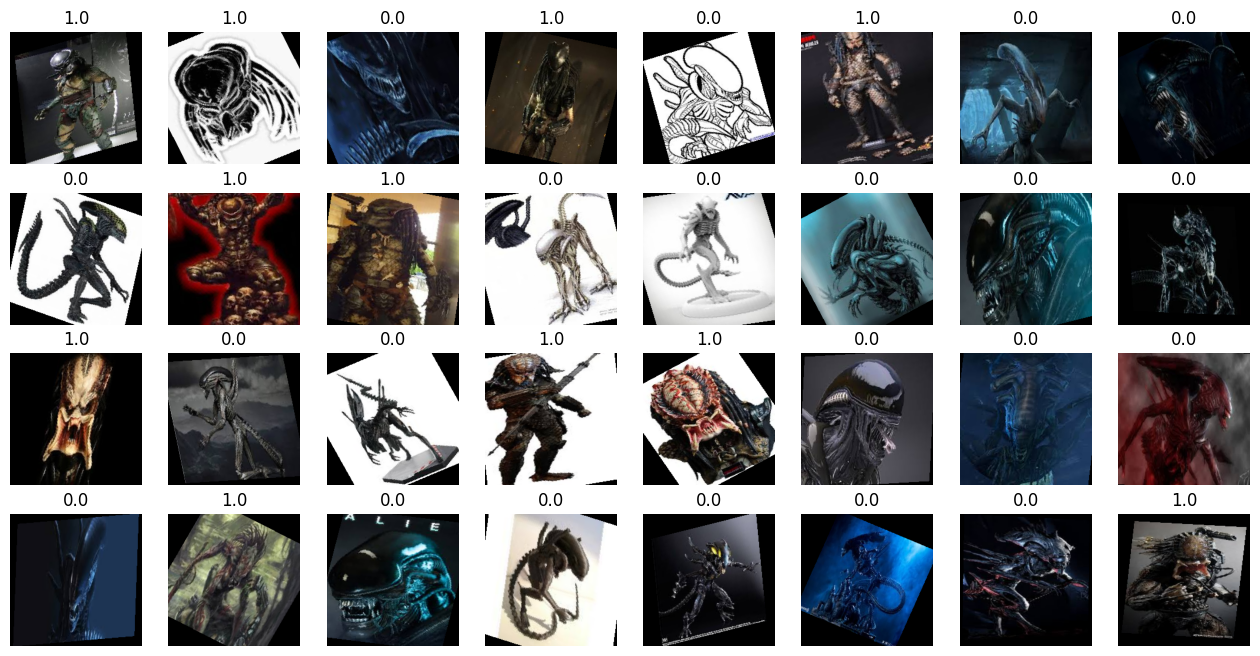

In [13]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3,224,224) -> (224,224,3)
    ax.set_title(label.item())
    ax.axis('off')

# **5. 사전학습된 ResNet 50 모델
[파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)


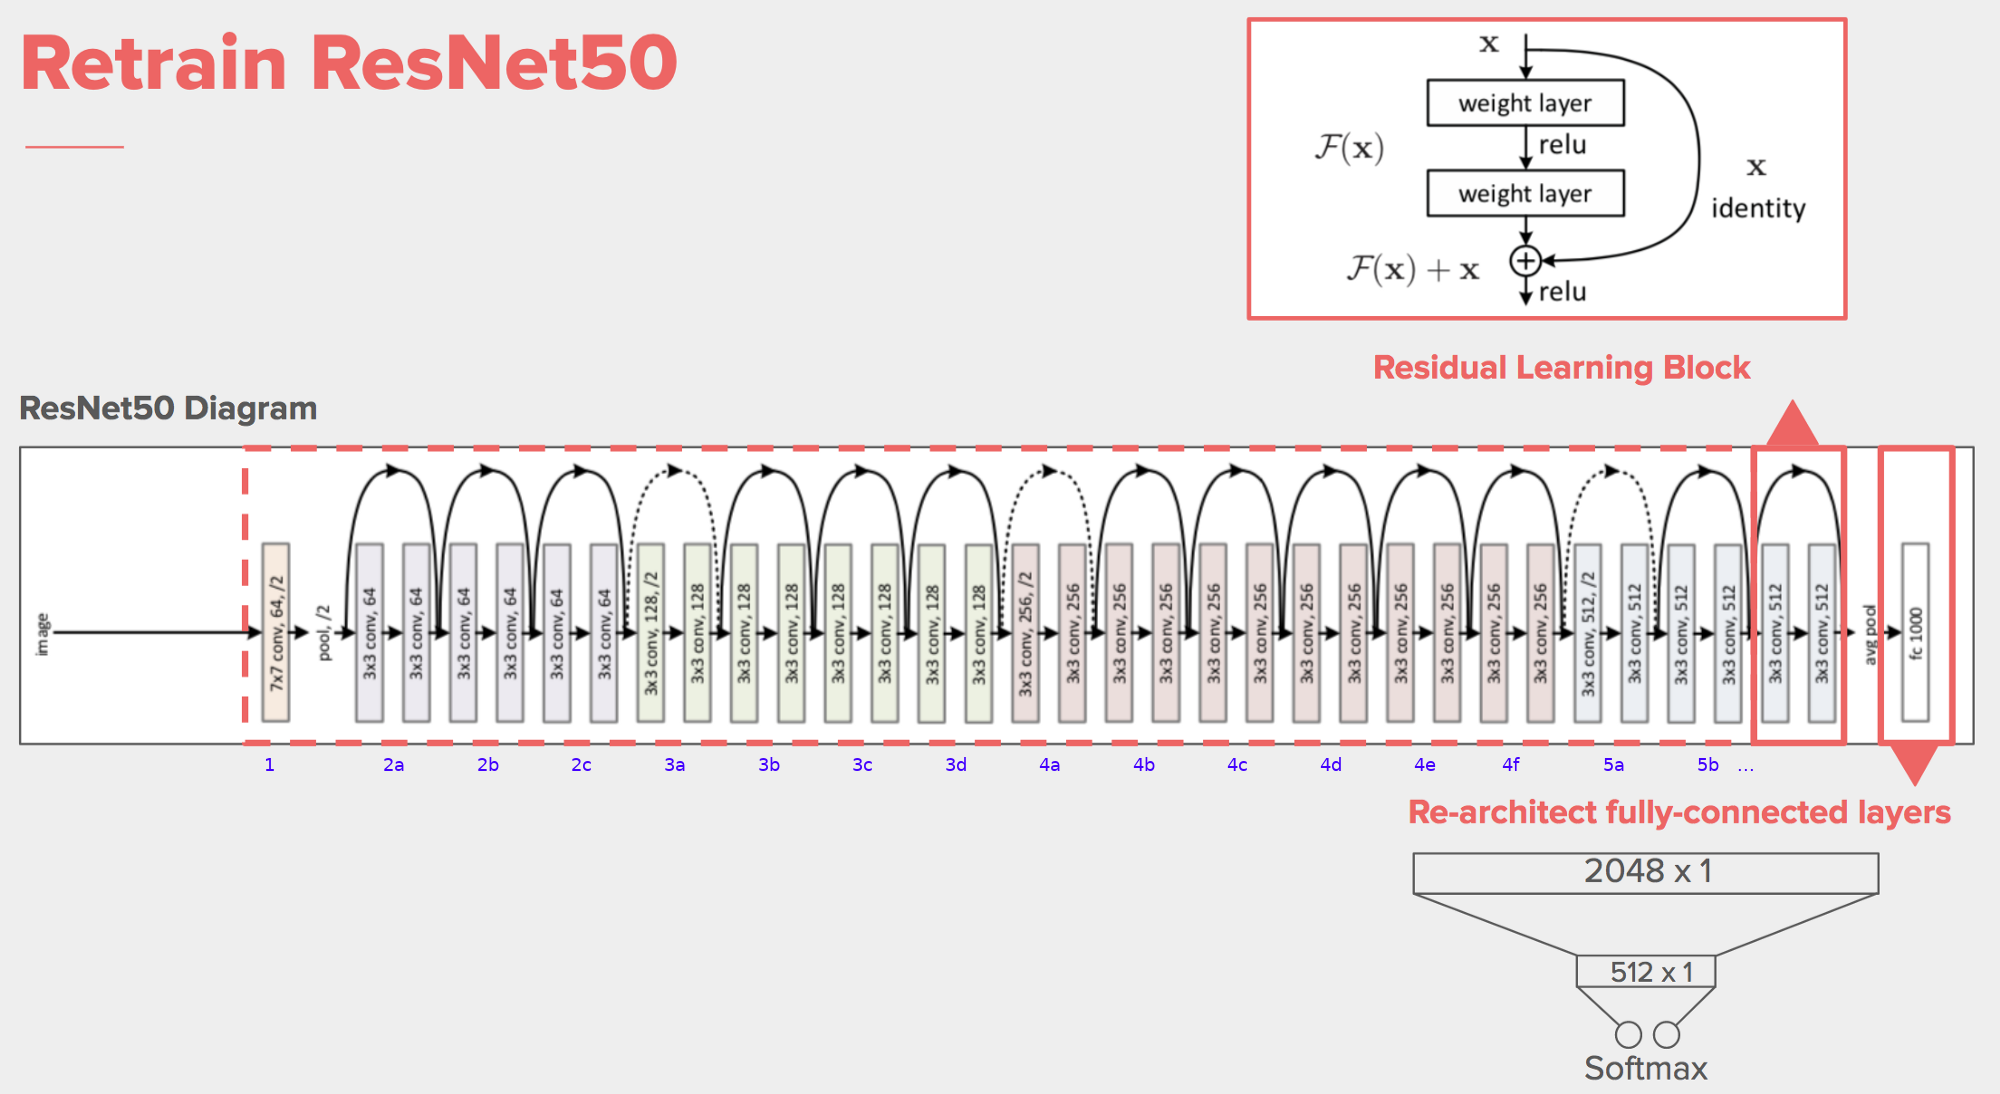

### *** 5-1. ResNet50의 특징 ***
* 50개의 레이어로 구성되어 있으며 주로 Conv(컨볼루션) 레이어와 Batch Normalization, ReLU 활성화 함수. 풀링 레이어 등으로 이루어져 있음 .
* 기울기 소실 문제를 해결하고 훨씬 더 깊은 네트워크를 효과적으로 학습시킬  수 있음.
*이미지 분류, 객체 탐지 등 다양한 컴튜저 비전 작업에서 높은 성능을 보임 .

### *** 5-2 이미지넷 (ImageNet) ***
![](https://i.imgur.com/5Rz5s8e.png)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
model = models.resnet50(weights ='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### *** 5-3. Freeze Layers ***
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 수정하지 않도록 설정
* 출력 부분의 레이어(FC)를 다시 설정하여 분류에 맞게 변경

In [17]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터를 업데이트 하지 않음

In [18]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
).to(device)

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [26]:
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)


            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            sum_losses = sum_losses + loss
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch)
            sum_accs = sum_accs + acc


        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 0.1506 Accuracy: 0.94%
validation: Epoch    1/10 Loss: 0.2186 Accuracy: 0.92%
train     : Epoch    2/10 Loss: 0.1725 Accuracy: 0.93%
validation: Epoch    2/10 Loss: 0.2733 Accuracy: 0.89%
train     : Epoch    3/10 Loss: 0.1281 Accuracy: 0.95%
validation: Epoch    3/10 Loss: 0.2428 Accuracy: 0.90%
train     : Epoch    4/10 Loss: 0.2016 Accuracy: 0.93%
validation: Epoch    4/10 Loss: 0.3074 Accuracy: 0.89%
train     : Epoch    5/10 Loss: 0.1398 Accuracy: 0.94%
validation: Epoch    5/10 Loss: 0.2131 Accuracy: 0.92%
train     : Epoch    6/10 Loss: 0.1695 Accuracy: 0.92%
validation: Epoch    6/10 Loss: 0.2861 Accuracy: 0.89%
train     : Epoch    7/10 Loss: 0.1705 Accuracy: 0.93%
validation: Epoch    7/10 Loss: 0.2724 Accuracy: 0.87%
train     : Epoch    8/10 Loss: 0.1430 Accuracy: 0.94%
validation: Epoch    8/10 Loss: 0.2233 Accuracy: 0.90%
train     : Epoch    9/10 Loss: 0.2845 Accuracy: 0.89%
validation: Epoch    9/10 Loss: 0.6850 Accuracy: 0.74%
train     

In [27]:
from PIL import Image

In [64]:
img1 = Image.open('/content/data/validation/alien/a.jpeg')
img2 = Image.open('/content/data/validation/alien/c.jpeg')

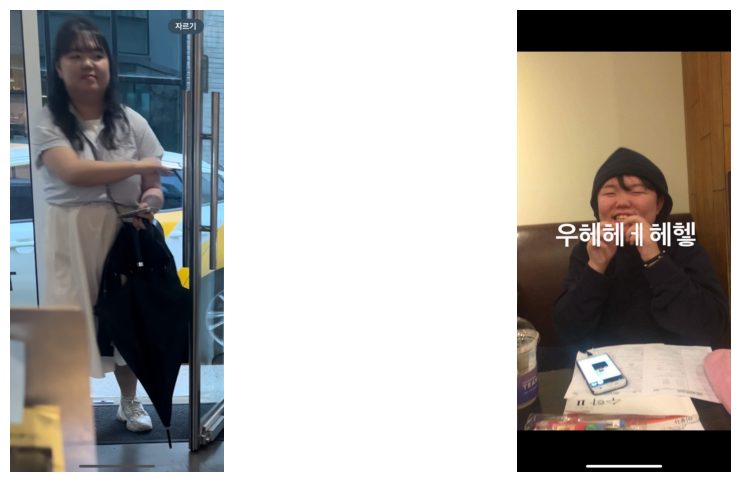

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [66]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [67]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [68]:
y_pred = model(test_batch)
y_pred # 0.5를 기준으로 0.5보다 크면 프레데터, 작으면 에일리언

tensor([[0.9801],
        [0.7295]], device='cuda:0', grad_fn=<SigmoidBackward0>)

(-0.5, 664.5, 1439.5, -0.5)

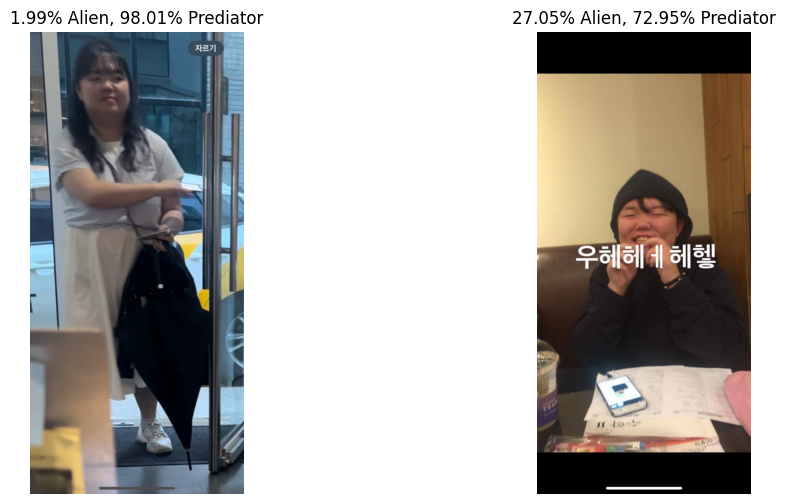

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Prediator')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Prediator')
axes[1].imshow(img2)
axes[1].axis('off')